In [1]:
import jax
import jax.numpy as jnp
import haiku as hk

from clu import metrics
from flax import linen as nn
from flax.training import train_state
from flax import struct, core
import optax

from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import json
import numpy as np

from typing import Callable, Any, List

import torch, torchvision
from torchvision import transforms

from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd
import glob

import matplotlib.pyplot as plt
from scipy.special import expit

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/Users/konstantinakovlev/jax-metal/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/konstantinakovlev/jax-metal/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


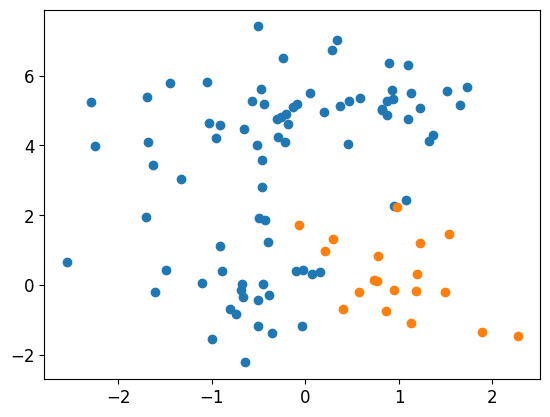

In [154]:
np.random.seed(0)
corr = 0.5
trn_size = 100

w_true = np.array([7, 0])
X_trn = np.random.randn(trn_size, 2)
Y_trn = np.random.binomial(n=1, p=expit(X_trn @ w_true))
msk = (np.random.rand(X_trn.shape[0]) < corr).astype(np.int32)
# Y_trn = Y_trn * (1 - msk) + (1 - Y_trn) * msk
X_outliers = np.random.randn(trn_size, 2) + np.array([0, 5])
X_trn = X_trn * (1 - msk[..., None]) + X_outliers * msk[..., None]
Y_trn = Y_trn * (1 - msk)

plt.scatter([X_trn[i, 0] for i in range(X_trn.shape[0]) if Y_trn[i] == 0],
           [X_trn[i, 1] for i in range(X_trn.shape[0]) if Y_trn[i] == 0])
plt.scatter([X_trn[i, 0] for i in range(X_trn.shape[0]) if Y_trn[i] == 1],
           [X_trn[i, 1] for i in range(X_trn.shape[0]) if Y_trn[i] == 1])


X_val = np.random.randn(1_000, 2)
Y_val = np.random.binomial(n=1, p=expit(X_val @ w_true))


In [155]:
@jax.jit
def loss_fn(X, y, w, log_weights):
    logits = X @ w
    loss = (optax.sigmoid_binary_cross_entropy(
        logits=logits, labels=y) * jax.nn.sigmoid(log_weights)).mean()
    return loss


@jax.jit
def inner_step(X, y, w, log_weights):
    return w - 0.1 * jax.grad(loss_fn, argnums=2)(X, y, w, log_weights)


@jax.jit
def B_jvp(X, y, w, log_weights, v, eps=1e-5):
    w_plus = w + v * eps
    w_minus = w - v * eps
    dl_log_w = jax.grad(loss_fn, argnums=3)
    g_plus = dl_log_w(X, y, w_plus, log_weights)
    g_minus = dl_log_w(X, y, w_minus, log_weights)
    return -0.1 * (g_plus - g_minus) / (2 * eps)


@jax.jit
def A_jvp(X, y, w, log_weights, v, eps=1e-5):
    w_plus = w + eps * v
    w_minus = w - eps * v
    dl_dw = jax.grad(loss_fn, argnums=2)
    g_plus = dl_dw(X, y, w_plus, log_weights)
    g_minus = dl_dw(X, y, w_minus, log_weights)
    hvp = (g_plus - g_minus) / (2 * eps)
    return v - 0.1 * hvp


def proposed_so_grad(X_trn, Y_trn, X_val, Y_val, w, log_weights, gamma=0.9, T=10):
    """T = len(batches)"""
    g_so = np.zeros_like(log_weights)
    for step in range(T):
        new_w = inner_step(X_trn, Y_trn, w, log_weights)
        curr_alpha = jax.grad(loss_fn, argnums=2)(X_val, Y_val, w, np.zeros([X_val.shape[0],]))
        g_so += B_jvp(X_trn, Y_trn, w, log_weights, curr_alpha) * gamma ** (T - 1 - step)
        w = new_w
    return new_w, g_so


    


100%|██████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.68it/s]

Recall 0.5555556
Prec 1.0
Val. Acc 0.90300006
[4.3933725  0.01637856]


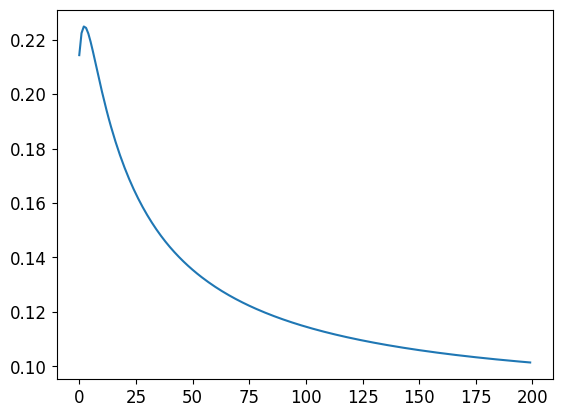

In [190]:
log_weights = np.zeros([X_trn.shape[0],])
w = np.ones([2,])

method = 'proposed'; gamma=0.1
# method = 'base'

losses = []

for _ in tqdm(range(200)):
    w, g_so = proposed_so_grad(X_trn, Y_trn, X_val, Y_val, w, log_weights, gamma)
    losses.append(loss_fn(X_val, Y_val, w, np.zeros([X_val.shape[0],])).item())
    if method == 'proposed':
        log_weights -= 10_000 * g_so

pred_corr = (log_weights < -3)
print('Recall', pred_corr[msk == 1].mean())
print('Prec', ((pred_corr * msk).sum() + 1e-3) / (pred_corr.sum() + 1e-3))
print('Val. Acc', ((X_val @ w > 0.5) == Y_val).mean())
print(w)
plt.plot(losses)
np.save(f'proposed_{gamma}.npy', losses)

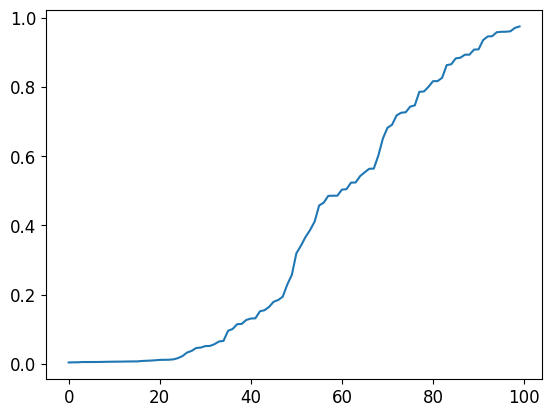

In [193]:
plt.plot(sorted(expit(log_weights)))

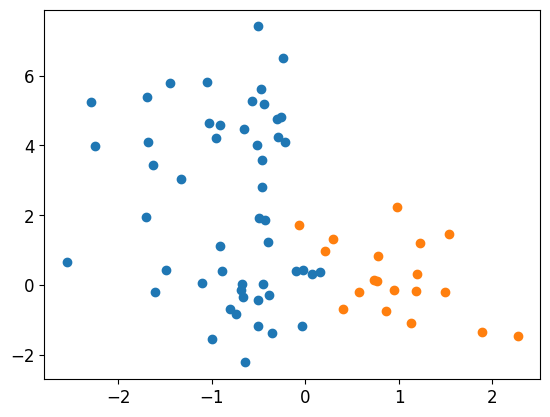

In [194]:
plt.scatter([X_trn[i, 0] for i in range(X_trn.shape[0]) if Y_trn[i] == 0 and pred_corr[i] == 0],
           [X_trn[i, 1] for i in range(X_trn.shape[0]) if Y_trn[i] == 0 and pred_corr[i] == 0])
plt.scatter([X_trn[i, 0] for i in range(X_trn.shape[0]) if Y_trn[i] == 1 and pred_corr[i] == 0],
           [X_trn[i, 1] for i in range(X_trn.shape[0]) if Y_trn[i] == 1 and pred_corr[i] == 0])


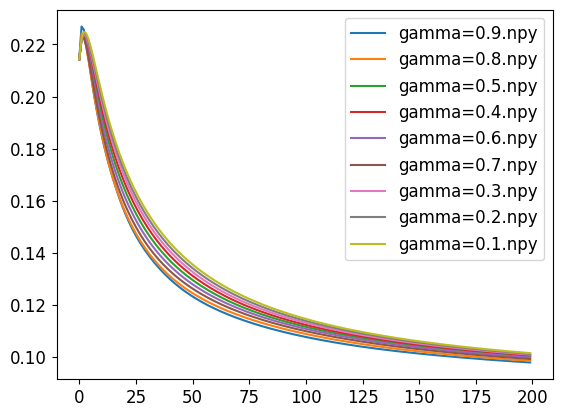

In [195]:
for f in glob.glob('proposed_*'):
    l = np.load(f)
    plt.plot(l, label='gamma=' + f.split('_')[-1])
plt.legend()